# *Suspicious sounds detection*

# Imports and Setup

In [ ]:
# Required imports
from fastai.vision.all import *
from fastai.callback.all import *
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm


# Define Dataset Paths

In [ ]:
# Path setup
DATASET_PATH = "/content"
AUDIO_DIR = os.path.join(DATASET_PATH, "audio")
METADATA_PATH = os.path.join(AUDIO_DIR, "filtered_UrbanSound8K.csv")


# Audio Preprocessing Utility

In [3]:
# Audio preprocessing
def load_and_preprocess_audio(file_path, sr=22050, duration=3):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))
        mel_spect = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=128, fmax=8000
        )
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        return mel_spect_db
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None


# Prepare Data

In [ ]:
# Data preparation
def prepare_data_for_fastai(metadata_path, audio_dir):
    metadata = pd.read_csv(metadata_path)
    df = pd.DataFrame({
        'fname': [os.path.join(audio_dir, f'fold{row.fold}', row.slice_file_name)
                 for _, row in metadata.iterrows()],
        'label': metadata['classID'],
        'fold': metadata['fold']
    })
    return df.reset_index(drop=True)


# Define FastAI DataBlock Accessors

In [ ]:
# FastAI data helpers
def get_x(row):
    mel_spect = load_and_preprocess_audio(row.fname)
    if mel_spect is None or mel_spect.size == 0:
        # Return a dummy image if processing fails
        return np.zeros((128, 128, 3), dtype=np.uint8)

    # Normalize to 0-1
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    # Convert to 3 channels
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    # Convert to uint8 (0-255) for PIL
    mel_spect_uint8 = (mel_spect_3d * 255).astype(np.uint8)
    return mel_spect_uint8

def get_y(row): return row.label


# Cross-Validation Training Function

In [ ]:
# K-Fold Cross-Validation
def run_cross_validation(df, n_folds=10):
    results = []
    for fold in range(1, n_folds + 1):
        print(f"\nTraining fold {fold}/{n_folds}")

        # Precompute validation indices
        val_idx = df.index[df['fold'] == fold].tolist()

        # Define the DataBlock
        db = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=get_x,
            get_y=get_y,
            splitter=IndexSplitter(val_idx),
            batch_tfms=[*aug_transforms(size=(128, 128)), Normalize]
        )

        # Create dataloaders
        dls = db.dataloaders(df, bs=32)
        learn = vision_learner(dls, resnet34, metrics=[accuracy],
                              cbs=[ShowGraphCallback()])

        # Find learning rate and train
        lr_suggestion = learn.lr_find(stop_div=False)  # stop_div=False to ensure it completes
        suggested_lr = lr_suggestion.valley

        learn.fit_one_cycle(5, suggested_lr)
        learn.unfreeze()
        learn.fit_one_cycle(10, slice(suggested_lr/10, suggested_lr))

        val_acc = learn.validate()[1]
        results.append(val_acc)
        print(f"Fold {fold} accuracy: {val_acc:.4f}")

    print(f"\nMean accuracy: {np.mean(results):.4f} ± {np.std(results):.4f}")
    return results


# Run Cross-Validation and Evaluate Performance

Checking paths...
Metadata file exists: True
Audio directory exists: True

Training fold 1/10


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 123MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.339112,0.422189,0.871595,01:09
1,0.752848,0.288134,0.902724,01:09
2,0.547111,0.253995,0.926070,01:05
3,0.426326,0.235512,0.914397,01:05
4,0.354421,0.248400,0.898833,01:07


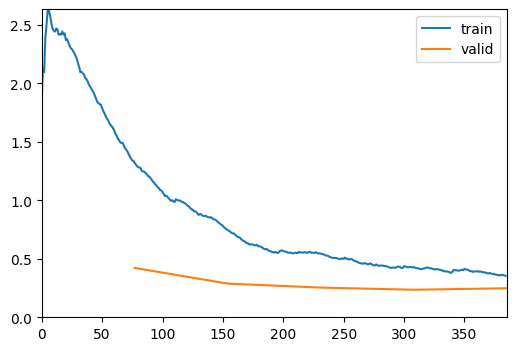

epoch,train_loss,valid_loss,accuracy,time
0,0.357611,0.234693,0.933852,01:11
1,0.313832,0.191771,0.949416,01:10
2,0.264026,0.154063,0.949416,01:12
3,0.197979,0.182478,0.945525,01:08
4,0.129647,0.040550,0.988327,01:08
5,0.125461,0.054476,0.980545,01:08
6,0.097140,0.046727,0.980545,01:09
7,0.071770,0.036800,0.980545,01:09
8,0.053101,0.027603,0.988327,01:08
9,0.036965,0.025408,0.992218,01:07


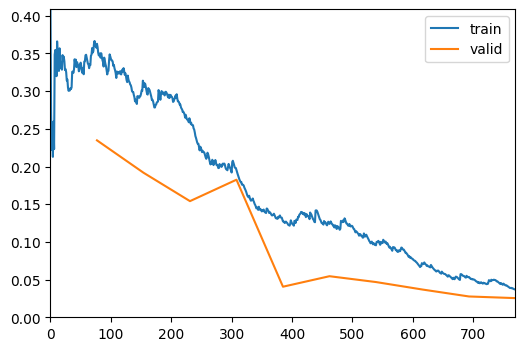

Fold 1 accuracy: 0.9922

Training fold 2/10


epoch,train_loss,valid_loss,accuracy,time
0,1.118328,0.726912,0.794776,01:09
1,0.653458,0.464315,0.850746,01:07
2,0.393651,0.484535,0.854478,01:09
3,0.356990,0.538342,0.832090,01:05
4,0.284681,0.433044,0.847015,01:07


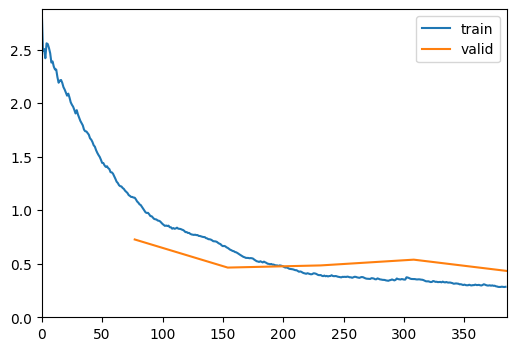

epoch,train_loss,valid_loss,accuracy,time
0,0.263238,0.711407,0.865672,01:10
1,0.271718,1.239840,0.884328,01:11
2,0.265726,0.488129,0.861940,01:07
3,0.212159,0.260622,0.921642,01:08
4,0.155336,0.198289,0.929105,01:09
5,0.124155,0.105262,0.962687,01:12
6,0.079637,0.103092,0.970149,01:11
7,0.058883,0.106672,0.951493,01:12
8,0.056072,0.124147,0.955224,01:10
9,0.047131,0.116026,0.951493,01:10


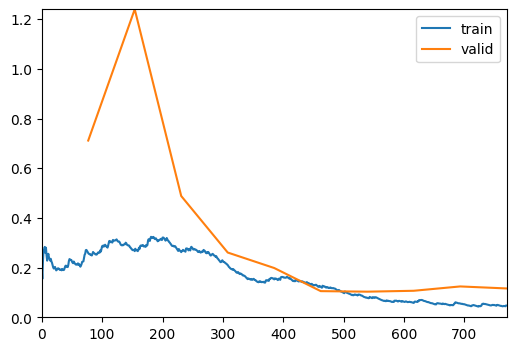

Fold 2 accuracy: 0.9515

Training fold 3/10


epoch,train_loss,valid_loss,accuracy,time
0,1.009603,0.303904,0.892617,01:07
1,0.548625,0.361531,0.882550,01:13
2,0.388591,0.164546,0.942953,01:10
3,0.279809,0.166194,0.926175,01:08
4,0.226235,0.168235,0.949664,01:05


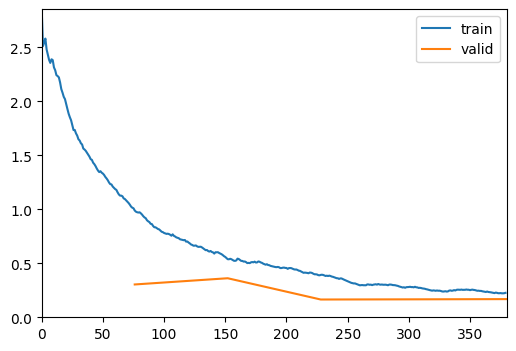

epoch,train_loss,valid_loss,accuracy,time
0,0.270917,0.273271,0.922819,01:09
1,0.275131,0.280250,0.926175,01:08
2,0.271195,0.230972,0.916107,01:06
3,0.206661,0.279887,0.919463,01:11
4,0.159261,0.337123,0.922819,01:11
5,0.136723,0.110291,0.966443,01:11
6,0.114624,0.088415,0.966443,01:12
7,0.059574,0.073152,0.976510,01:12
8,0.043982,0.083179,0.973154,01:07
9,0.032360,0.082469,0.973154,01:10


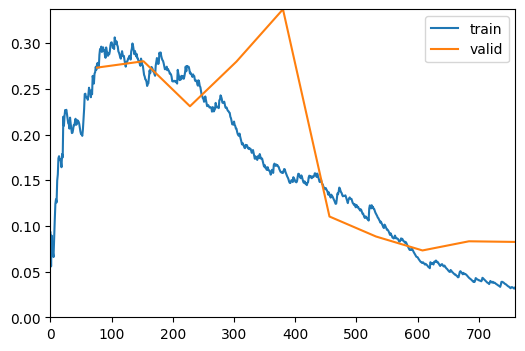

Fold 3 accuracy: 0.9732

Training fold 4/10


epoch,train_loss,valid_loss,accuracy,time
0,1.172443,0.496189,0.851240,01:09
1,0.661092,0.513601,0.878788,01:11
2,0.444856,0.307200,0.906336,01:12
3,0.330833,0.324442,0.920110,01:11
4,0.292729,0.309962,0.917355,01:10


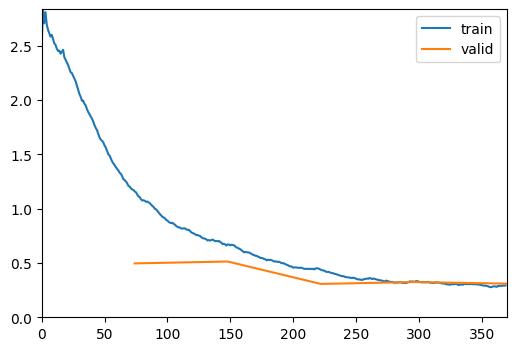

epoch,train_loss,valid_loss,accuracy,time
0,0.289484,0.524837,0.911846,01:08
1,0.292566,0.445334,0.892562,01:08
2,0.258997,0.227468,0.931129,01:11
3,0.198139,0.205496,0.911846,01:12
4,0.145834,0.208336,0.933884,01:09
5,0.152028,0.192087,0.939394,01:09
6,0.100684,0.115584,0.964187,01:07
7,0.059109,0.165341,0.964187,01:09
8,0.061801,0.120329,0.972452,01:09
9,0.040983,0.133378,0.972452,01:11


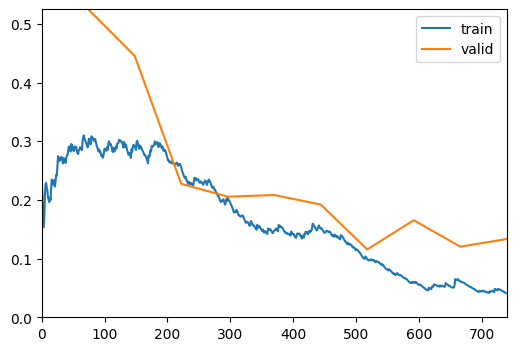

Fold 4 accuracy: 0.9725

Training fold 5/10


epoch,train_loss,valid_loss,accuracy,time
0,1.357926,0.544128,0.776699,01:10
1,0.796037,0.380258,0.854369,01:07
2,0.529672,0.413396,0.880259,01:04
3,0.429031,0.315405,0.886731,01:09
4,0.414166,0.316433,0.899676,01:09


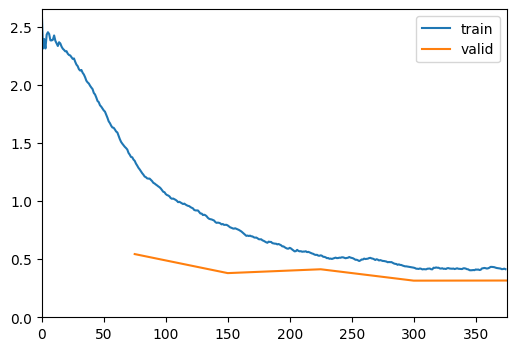

epoch,train_loss,valid_loss,accuracy,time
0,0.360816,0.334552,0.919094,01:09
1,0.300196,0.319164,0.915858,01:07
2,0.262069,0.236585,0.915858,01:09
3,0.215655,0.102641,0.954693,01:08
4,0.167793,0.082779,0.964401,01:13
5,0.104829,0.077165,0.967638,01:13
6,0.117310,0.065317,0.977346,01:13
7,0.075503,0.085605,0.974110,01:09
8,0.048736,0.055169,0.977346,01:12
9,0.052336,0.049432,0.977346,01:09


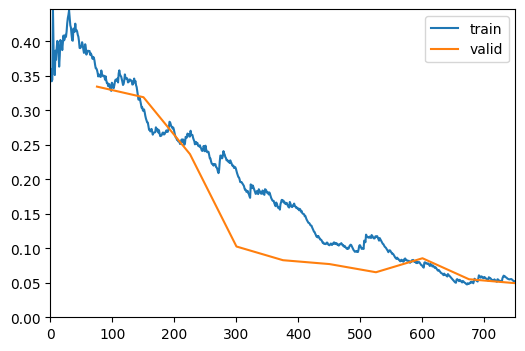

Fold 5 accuracy: 0.9773

Training fold 6/10


epoch,train_loss,valid_loss,accuracy,time
0,1.051651,0.307759,0.895161,01:06
1,0.628451,0.264662,0.919355,01:13
2,0.480489,0.314680,0.903226,01:16
3,0.335584,0.155518,0.967742,01:14
4,0.281803,0.171807,0.955645,01:13


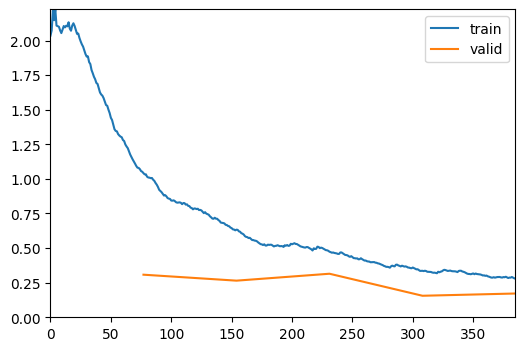

epoch,train_loss,valid_loss,accuracy,time
0,0.303883,0.193640,0.927419,01:10
1,0.321753,0.343198,0.895161,01:10
2,0.253619,0.314229,0.907258,01:11
3,0.168056,0.238402,0.899194,01:13
4,0.143032,0.171824,0.943548,01:09
5,0.109338,0.307552,0.923387,01:16
6,0.097765,0.153222,0.955645,01:11
7,0.073673,0.312696,0.927419,01:11
8,0.043480,0.321864,0.931452,01:12
9,0.033841,0.221080,0.943548,01:14


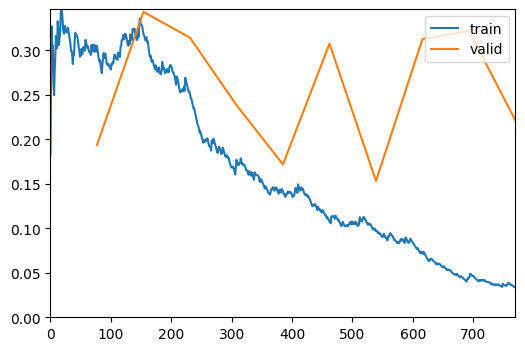

Fold 6 accuracy: 0.9435

Training fold 7/10


epoch,train_loss,valid_loss,accuracy,time
0,1.065518,0.525515,0.843750,01:13
1,0.607264,0.510156,0.847656,01:11
2,0.430665,0.430745,0.886719,01:10
3,0.325892,0.371595,0.875000,01:11
4,0.299913,0.403277,0.878906,01:11


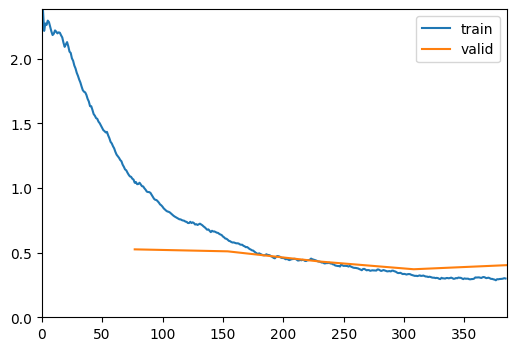

epoch,train_loss,valid_loss,accuracy,time
0,0.220297,0.538044,0.871094,01:13
1,0.279330,0.517394,0.859375,01:14
2,0.215575,0.460240,0.882812,01:11
3,0.179860,0.197687,0.949219,01:09
4,0.163560,0.333299,0.902344,01:11
5,0.088653,0.226481,0.933594,01:12
6,0.080917,0.164346,0.960938,01:13
7,0.064780,0.189884,0.937500,01:10
8,0.060750,0.162658,0.960938,01:13
9,0.035894,0.166038,0.964844,01:12


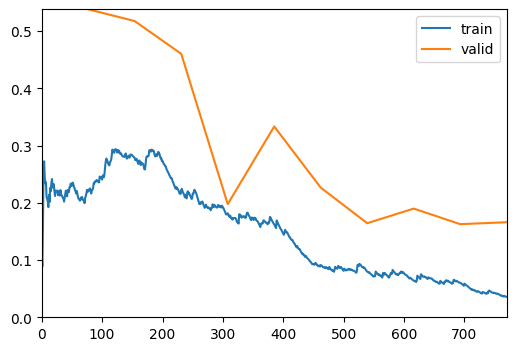

Fold 7 accuracy: 0.9648

Training fold 8/10


epoch,train_loss,valid_loss,accuracy,time
0,0.913907,0.882760,0.750000,01:13
1,0.584029,0.735694,0.729167,01:10
2,0.377625,0.358450,0.795833,01:12
3,0.296454,0.325324,0.812500,01:09
4,0.220672,0.365353,0.804167,01:12


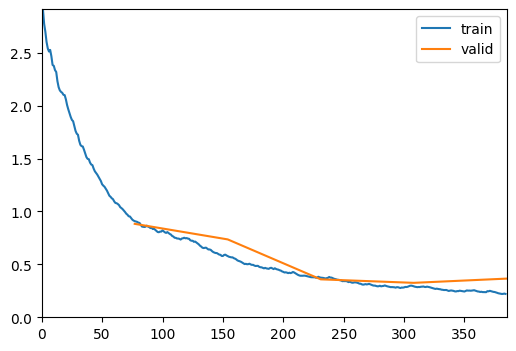

epoch,train_loss,valid_loss,accuracy,time
0,0.281427,0.603647,0.870833,01:10
1,0.321496,0.453457,0.929167,01:11
2,0.252048,0.238225,0.929167,01:10
3,0.200444,0.458580,0.825000,01:12
4,0.160887,0.418107,0.850000,01:11
5,0.150000,0.240077,0.866667,01:12
6,0.113136,0.185563,0.941667,01:12
7,0.070065,0.132700,0.950000,01:13
8,0.049210,0.123123,0.958333,01:12
9,0.033387,0.105419,0.962500,01:13


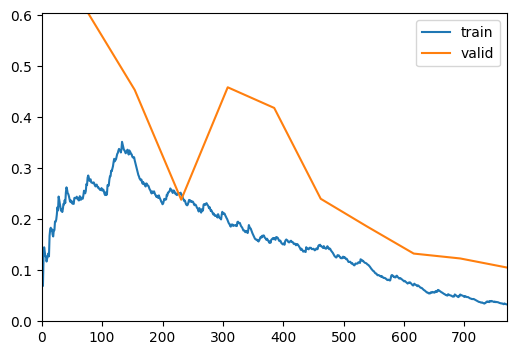

Fold 8 accuracy: 0.9625

Training fold 9/10


epoch,train_loss,valid_loss,accuracy,time
0,1.025437,0.405758,0.840816,01:11
1,0.565498,0.300489,0.885714,01:16
2,0.390694,0.212833,0.934694,01:08
3,0.310136,0.154629,0.938776,01:13
4,0.255452,0.166925,0.942857,01:12


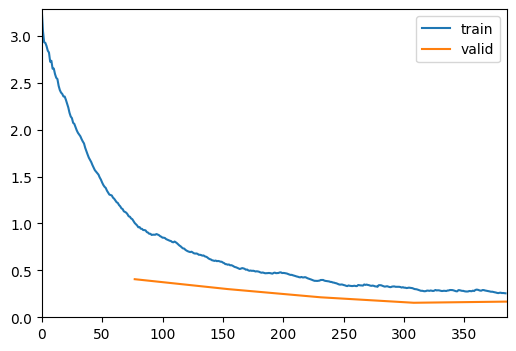

epoch,train_loss,valid_loss,accuracy,time
0,0.273874,0.300163,0.902041,01:11
1,0.313434,0.353090,0.844898,01:13
2,0.275070,0.072442,0.963265,01:12
3,0.228636,0.147453,0.926531,01:10
4,0.166983,0.279605,0.918367,01:11
5,0.135201,0.069828,0.959184,01:11
6,0.082693,0.143341,0.955102,01:10
7,0.070027,0.072492,0.987755,01:13
8,0.051703,0.068722,0.971429,01:11
9,0.042836,0.059440,0.983673,01:10


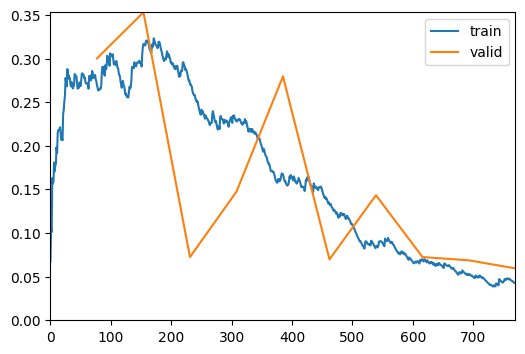

Fold 9 accuracy: 0.9837

Training fold 10/10


epoch,train_loss,valid_loss,accuracy,time
0,1.063926,0.720252,0.782258,01:11


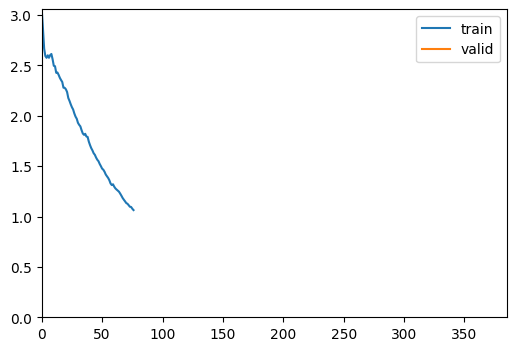

In [ ]:
df = prepare_data_for_fastai(METADATA_PATH, AUDIO_DIR)
print("Checking paths...")
print(f"Metadata file exists: {os.path.exists(METADATA_PATH)}")
print(f"Audio directory exists: {os.path.exists(AUDIO_DIR)}")
# Run K-Fold
results = run_cross_validation(df)
